# Collocation

<a target="_blank" href="https://colab.research.google.com/github/arthurrichards77/smply/blob/master/collocation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The collocation approach solves nonlinear trajectory optimization essentially by curve-fitting.  The decision variables are the states and controls at a set of _collocation points_.  These are enough to determine polynomials that interpolate the collocation points, so the derivative values of these quantities are also known.  An analytical model of the dynamics is used to enforce the differential constraints ~$\dot{\vec{x}}(t) = f(\vec{x}(t), \vec{u}(t))$ at the collocation points.  This ensures the solution satisfies, approximately, the differential equation of the dynamics, without the overhead of numerical integration (see Shooting Method).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

## System model

This example uses the collocation approach to find a time-minimising trajectory between a start and end location for a simple vehicle with steering (curvature) and speed control inputs.

The states and controls of the model are given in the table.

<center>

| Value | Type | Description |
|:-:|:-:|:-:|
| $x$ | state | x position |
| $y$ | state | y position |
| $h$ | state | heading angle |
| $v$ | control | velocity |
| $k$ | control | steering (curvature) input |

</center>

The dynamics equations for the vehicle are

\begin{align*}
    \dot{x}(t) &= v(t) \sin(h(t)) \\
    \dot{y}(t) &= v(t) \cos(h(t)) \\
    \dot{h}(t) &= v(t) k(t)
\end{align*}

where the equation for $\dot{h}$ shows that the steering control input $k$ changes the vehicle's orientation, proportional to the vehicle's speed at the associated point in time.

In [2]:
# Define starting and ending positions and orientations
s0 = (0,0,0.5*np.pi)
sf = (0.7,0.7,-0.5*np.pi)

## Collocation implementation

In the collocation approach, the state and control values over a trajectory are parametrised by interpolating polynomials, allowing the trajectory to discreted and solved with discrete optimisation techniques. To ensure the feasibility of the resulting state histories, their interpolating polynomials are 'collocated' with the system dynamics at the interpolation points (called collocation points). The choice of interpolation points affects the accuracy of the approximation of the true state histories by the interpolating polynomials. To minimise the error, we use the [Chebyshev nodes of the first kind](https://en.wikipedia.org/wiki/Chebyshev_nodes).

Collocation points: [0.         0.10908426 0.28305813 0.5        0.71694187 0.89091574
 1.        ]


Text(0.5, 0.98, 'Collocation points')

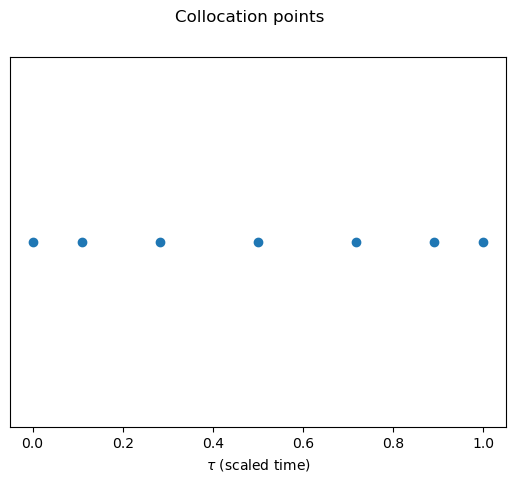

In [33]:
# Create grid for collocation - Chebyshev nodes
num_colloc = 7 # 18
colloc_dist = 0.5 - 0.5*np.cos([(2*k+1)*np.pi/(2*num_colloc) for k in range(num_colloc)])
colloc_dist[0] = 0.0
colloc_dist[-1] = 1.0

print(f"Collocation points: {colloc_dist}")

fig, ax = plt.subplots()
ax.scatter(colloc_dist, np.zeros(colloc_dist.size))
ax.set_yticks([])
ax.set_xlabel(r'$\tau$ (scaled time)')
fig.suptitle("Collocation points")

Given a set of points and corresponding values $(\tau_i, y_i), \tau_i \in [0, 1]$ one way to construct an interpolating polynomial is as follows.

Let the interpolating polynomial be $p(\tau) = a_n \tau^n + a_{n-1} \tau^{n-1} + ... + a_2 \tau^2 + a_1 \tau + a_0$.

We know that $p(\tau_i) = y_i$, so can construct the linear system

\begin{equation*}
\begin{bmatrix}
1 & \tau_0 & \tau_0^2 & \dots & \tau_0^n\\
1 & \tau_1 & \tau_1^2 & \dots & \tau_1^n\\
1 & \tau_2 & \tau_2^2 & \dots & \tau_2^n\\
\vdots & \vdots & \vdots & \ddots &\vdots \\
1 & \tau_m & \tau_m^2 & \dots & \tau_m^n
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
\vdots \\
a_n \\
\end{bmatrix} =
\begin{bmatrix}
y_0 \\
y_1 \\
y_2 \\
\vdots \\
y_n \\
\end{bmatrix}
\end{equation*}

where $\tau_i$ is the i<sup>th</sup> interpolation/collocation point. The large, leftmost matrix is called the Vandermonde matrix.

Denoting the equation as $\mathbf{V}\vec{a} = \vec{y}$, we can invert $\mathbf{V}$ ([this is always possible](https://en.wikipedia.org/wiki/Vandermonde_matrix)) to find the interpolation coefficient values $a_0, ..., a_n$ as

\begin{equation*}
    \vec{a} = \mathbf{V}^{-1}\vec{y} .
\end{equation*}

We then have that, for any value $\tau \in [0, 1]$

\begin{equation*}
    p(\tau) = \sum_{i = 0}^n a_i \tau^i
\end{equation*}

In [4]:
# Compute the Vandermonde matrix
vand = np.array([colloc_dist**i for i in range(num_colloc)]).T
vand

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.09084259e-01, 1.18993755e-02, 1.29803456e-03,
        1.41595138e-04, 1.54458006e-05, 1.68489371e-06],
       [1.00000000e+00, 2.83058130e-01, 8.01219052e-02, 2.26791567e-02,
        6.41951969e-03, 1.81709724e-03, 5.14344148e-04],
       [1.00000000e+00, 5.00000000e-01, 2.50000000e-01, 1.25000000e-01,
        6.25000000e-02, 3.12500000e-02, 1.56250000e-02],
       [1.00000000e+00, 7.16941870e-01, 5.14005644e-01, 3.68512168e-01,
        2.64201802e-01, 1.89417334e-01, 1.35801218e-01],
       [1.00000000e+00, 8.90915741e-01, 7.93730858e-01, 7.07147316e-01,
        6.30008675e-01, 5.61284646e-01, 5.00057326e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

Collocation works by comparing the derivates of the interpolating polynomials at the collocation points with the state rates given by the system dynamics model, and varying the state and control values until these coincide. This requires a way to differentiate the state interpolating polynomials. Luckily it's particularly easy to calculate the derivative of a polynomial; by linearity, every term is just differented individually. We can calculate a new matrix related to the Vandermonde matrix to differentiate the interpolating polynomials.

Let
\begin{equation*}
\mathbf{D} = \begin{bmatrix}
0 & 1 \cdot \tau_0^0 & 2 \tau_0^1 & 3 \tau_0^2 & \dots & n \tau_0^{n-1}\\
0 & 1 \cdot \tau_0^0 & 2 \tau_1^1 & 3 \tau_1^2 & \dots & n \tau_1^{n-1}\\
0 & 1 \cdot \tau_0^0 & 2 \tau_2^1 & 3 \tau_2^2 & \dots & n \tau_2^{n-1}\\
\vdots & \vdots & \vdots & \vdots & \ddots &\vdots \\
0 & 1 \cdot \tau_0^0 & 2 \tau_n^1 & 3 \tau_n^2 & \dots & n \tau_n^{n-1}
\end{bmatrix} \equiv 
\begin{bmatrix}
0 & 1 & 2 \tau_0 & 3 \tau_0^2 & \dots & n \tau_0^{n-1}\\
0 & 1 & 2 \tau_1 & 3 \tau_1^2 & \dots & n \tau_1^{n-1}\\
0 & 1 & 2 \tau_2 & 3 \tau_2^2 & \dots & n \tau_2^{n-1}\\
\vdots & \vdots & \vdots & \vdots & \ddots &\vdots \\
0 & 1 & 2 \tau_n & 3 \tau_n^2 & \dots & n \tau_n^{n-1}
\end{bmatrix}
\end{equation*} .

Then since, for any value of $\tau$,

\begin{equation*}
\begin{bmatrix}
0 \\
1 \\
2 \tau \\
3 \tau^2 \\
\vdots \\
n \tau^{n-1}
\end{bmatrix} \cdot
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\vdots \\
a_n \\
\end{bmatrix} = a_n \cdot n \tau^{n-1} + a_{n-1} \cdot (n - 1) \tau^{n-2} + \dots + a_2 \cdot 2 \tau + a_1 = \dot{p}(\tau)
\end{equation*} ,

we have

\begin{equation*}
\mathbf{D} \vec{a} =
\begin{bmatrix}
0 & 1 & 2 \tau_0 & 3 \tau_0^2 & \dots & n \tau_0^{n-1}\\
0 & 1 & 2 \tau_1 & 3 \tau_1^2 & \dots & n \tau_1^{n-1}\\
0 & 1 & 2 \tau_2 & 3 \tau_2^2 & \dots & n \tau_2^{n-1}\\
\vdots & \vdots & \vdots & \vdots & \ddots &\vdots \\
0 & 1 & 2 \tau_n & 3 \tau_n^2 & \dots & n \tau_n^{n-1}
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
\vdots \\
a_n \\
\end{bmatrix} =
\begin{bmatrix}
\dot{p}_0 \\
\dot{p}_1 \\
\dot{p}_2 \\
\vdots \\
\dot{p}_n \\
\end{bmatrix}
\end{equation*} ,

where $\dot{p}_i$ is the derivative of $p$ at the i<sup>th</sup> interpolation/collocation point. The rows of $\mathbf{D}$ are the points for which we want the derivatives of the interpolating polynomial with coefficients in $\vec{a}$.

In [5]:
# Compute the differentiation matrix (for known interpolation coefficients a0...an).
diff_from_coeffs = np.vstack((colloc_dist*0,  np.array([i*colloc_dist**(i-1) for i in range(1,num_colloc)]))).T
diff_from_coeffs

array([[0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 2.18168518e-01, 3.56981265e-02,
        5.19213823e-03, 7.07975688e-04, 9.26748037e-05],
       [0.00000000e+00, 1.00000000e+00, 5.66116261e-01, 2.40365716e-01,
        9.07166268e-02, 3.20975985e-02, 1.09025835e-02],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 7.50000000e-01,
        5.00000000e-01, 3.12500000e-01, 1.87500000e-01],
       [0.00000000e+00, 1.00000000e+00, 1.43388374e+00, 1.54201693e+00,
        1.47404867e+00, 1.32100901e+00, 1.13650400e+00],
       [0.00000000e+00, 1.00000000e+00, 1.78183148e+00, 2.38119257e+00,
        2.82858926e+00, 3.15004337e+00, 3.36770787e+00],
       [0.00000000e+00, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 5.00000000e+00, 6.00000000e+00]])

The optimiser adjusts the state and control values simultaneously to derive a solution which is both dynamically feasible and the best possible trajectory according to an objective function provided.

Using interpolating polynomials to represent the state and control histories converts the continuous-time trajectory optimisation problem into a discrete-time one which can be solved as a nonlinear program, using general off-the-shelf solvers such as those found in Scipy's optimisation package. The key is that the system dynamics are enforced as constraints in the optimiser - e.g. for a solution to be feasible to the optimiser, the state rates at the collocation points, given as the derivatives of the interpolating polynomials at these points, must match the state rates given by the system dynamics equations. Mathematically, this is the condition

\begin{equation*}
    \dot{p}_{s_i}(\tau_i) = \frac{ds_i}{dt} (\tau_i)
\end{equation*}

where $p_{s_i}$ is the interpolating polynomial of state $i$, in this case x, y or h, and $\frac{ds_i}{dt}$ is the analytical derivative provided by the system model. This condition must be satisfied for all states and at all collocation points, hence there are (number of states) x (number of collocation points) dynamics constraints in the optimisation, along with any others which might be provided to further constrain the behaviour of the solution.

To perform the optimisation, the x, y, h, v and k values at the interpolation/collocation points are concatenated into a single vector representing the combined state of the problem to the optimiser.

In this implementation, the interpolation grid used for the collocation is defined on the interval [0, 1], and is scaled to the actual problem by multiplying by the total trajectory time $T$. $T$ is therefore part of the problem formulation, and a quantity that we want to minimise, so it is also passed to the optimiser as part of the combined state vector.

The function below separates the state, control and total trajectory time values back out from the vector used by the optimiser; this is required to calculate the constraint violations.

In [6]:
def extract_components(z):
    x = z[0:num_colloc]
    y = z[num_colloc:(2*num_colloc)]
    h = z[(2*num_colloc):(3*num_colloc)]
    v = z[(3*num_colloc):(4*num_colloc)]
    k = z[(4*num_colloc):(5*num_colloc)]
    T = z[(5*num_colloc)]
    return x,y,h,v,k,T

In [7]:
# This function calculates the defects in the gradients at the collocation nodes (the differences between the
# state rates given by the system dynamics and interpolating polynomials).

# V^-1 * s = a (interpolation coefficients)  [s is a state - x, y or h]
# D * V^-1 * s = D * a = derivatives of interpolating polynomial at points defined in rows of D (the collocation points)
diff = diff_from_coeffs@np.linalg.inv(vand)

def dynamics_constraints(z):
    x,y,h,v,k,T = extract_components(z)
    # (1/T) => scale to tau space
    xdot_err = (1/T)*diff@x - v*np.sin(h) # x-dot = v sin h
    ydot_err = (1/T)*diff@y - v*np.cos(h) # y-dot = v cos h
    hdot_err = (1/T)*diff@h - v*k # h-dot = v k
    return np.hstack((xdot_err,ydot_err,hdot_err))

In [8]:
# This function calculates the violation of the boundary constraints. It will return [0, 0, 0, 0, 0, 0] when the
# boundary constraints are satisfied, meaning that x, y and h assume their desired values at the beginning and
# end of the trajectory.
def boundary_constraints(z):
    init_err = np.array([s0[i] - z[i*num_colloc] for i in range(len(s0))])
    term_err = np.array([sf[i] - z[num_colloc + i*num_colloc - 1] for i in range(len(sf))])
    return np.hstack((init_err,term_err))

In [9]:
# This just combines the dynamics and boundary constraints for the optimisation package used
def all_eq_constraints(z):
    return np.hstack((dynamics_constraints(z),boundary_constraints(z)))

## Problem setup

To optimise the trajectory, we require
 - Constraints (set up above) to enforce the system dynamics and the desired behaviour at the beginning and end of the trajectory.
 - A cost function, to determine which of the feasible trajectories (those satisfying the system dynamics) is best.
 - Bounds on the states and controls, to ensure that they remain valid in the context of the physical problem.
 - An initial guess for the optimiser. This provides initial values for the states and controls at each collocation node (plus the final trajectory time) as a starting point for the optimisation. 

Dynamics constraint violation (collocation defects): [-0.72986094 -0.69648979 -0.38684648  0.10585266  0.61315352  1.03556102
  1.27013906  0.27013906 -0.33046439 -0.75287188 -0.89414734 -0.75287188
 -0.33046439  0.27013906 -1.21238127 -0.76087406 -0.50783182 -0.47506564
 -0.50783182 -0.76087406 -1.21238127]
Boundary constraint violation: [0. 0. 0. 0. 0. 0.]


Text(0.5, 0.98, 'Initial guess')

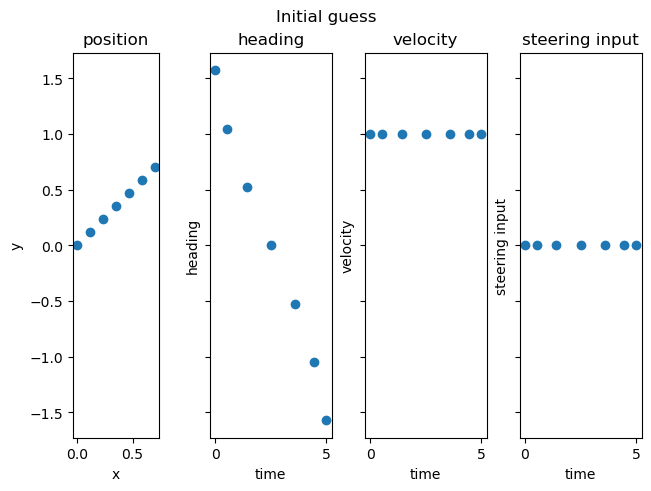

In [10]:
# Initial guess
bc_test_z = np.hstack((np.linspace(s0[0],sf[0],num_colloc),
                    np.linspace(s0[1],sf[1],num_colloc),
                    np.linspace(s0[2],sf[2],num_colloc),
                    np.ones_like(colloc_dist),
                    np.zeros_like(colloc_dist),
                    5.0))

# Show initial dynamics and boundary errors
print(f"Dynamics constraint violation (collocation defects): {dynamics_constraints(bc_test_z)}")
print(f"Boundary constraint violation: {boundary_constraints(bc_test_z)}")

# Plot initial guess
fig, axs = plt.subplots(1, 4, layout="constrained", sharey=True)
xs, ys, hs, vs, ks, T = extract_components(bc_test_z)

axs[0].scatter(xs, ys)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('position')
axs[0].set_aspect("equal")

axs[1].scatter(colloc_dist*T, hs)
axs[1].set_xlabel('time')
axs[1].set_ylabel('heading')
axs[1].set_title('heading')

axs[2].scatter(colloc_dist*T, vs)
axs[2].set_xlabel('time')
axs[2].set_ylabel('velocity')
axs[2].set_title('velocity')

axs[3].scatter(colloc_dist*T, ks)
axs[3].set_xlabel('time')
axs[3].set_ylabel('steering input')
axs[3].set_title('steering input')

fig.suptitle("Initial guess")

In [11]:
# State and control bounds
vmax = 1.0
vmin = 0.1
kmax = 6.0

# (x, y), h, v, k, T
bounds = [(-1,1)]*2*num_colloc + [(-2*np.pi,2*np.pi)]*num_colloc + [(vmin,vmax)]*num_colloc + [(-kmax,kmax)]*num_colloc + [(0.001,100.0)]
bounds

[(-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-1, 1),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (-6.283185307179586, 6.283185307179586),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (0.1, 1.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (-6.0, 6.0),
 (0.001, 100.0)]

In [12]:
constraints = [{'type':'eq','fun':all_eq_constraints}]

In [13]:
# Define cost function - minimising T (total trajectory time)
def cost(z):
    return(z[-1])

## Optimise!

By interpolating the state and control trajectories with a set of discrete points, with constraints enforcing the system dynamics, we've turned the continuous trajectory optimisation problem into a discrete nonlinear program which can be solved with generic off-the-shelf optimisers. We use SLSQP from Scipy's optimisation package to solve for the optimal trajectory. 

In [14]:
res = minimize(cost,bc_test_z,method='SLSQP',bounds=bounds,constraints=constraints,options={'maxiter':1000})
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.3822461367095893
       x: [-1.371e-19  1.290e-01 ... -6.000e+00  1.382e+00]
     nit: 43
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 1596
    njev: 43

## Results analysis

In [15]:
x,y,h,v,k,T = extract_components(res.x)

The raw state and control values at the collocation nodes can be plotted:

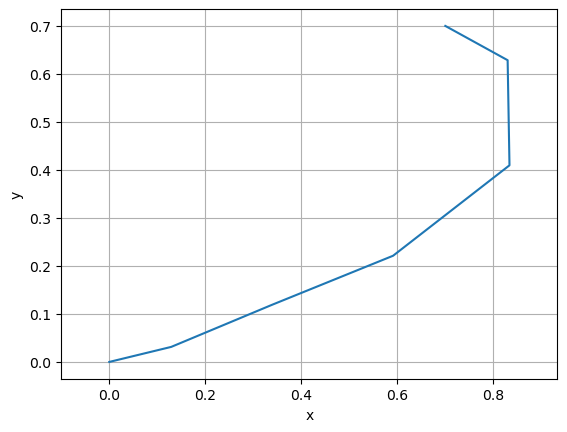

In [16]:
plt.plot(x,y)
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

...including the boundaries on their values, to check that they're respected:

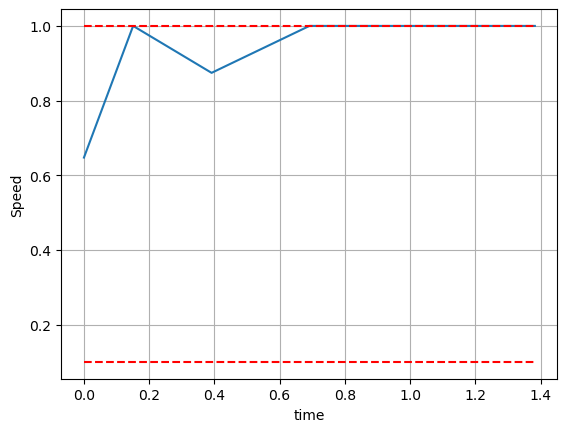

In [17]:
plt.plot(T*colloc_dist, v)
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('Speed')
plt.show()

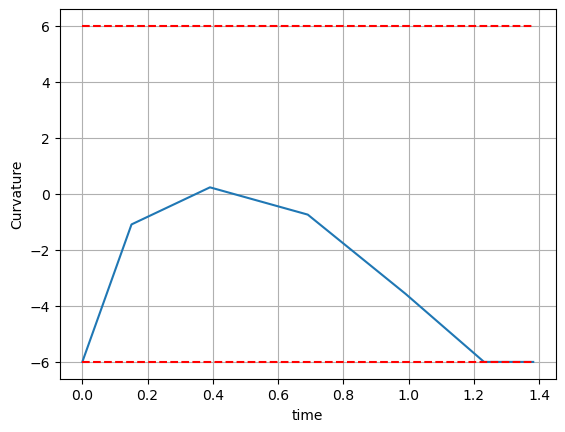

In [18]:
plt.plot(T*colloc_dist,k)
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('Curvature')
plt.show()

We can also calculate and show the interpolating polynomials:

In [19]:
intv = 1000
eval_dist = np.linspace(0,1,intv)

In [20]:
coeffs_to_eval = np.array([eval_dist**i for i in range(len(colloc_dist))]).T
coeffs_to_eval

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00100100e-03, 1.00200300e-06, ...,
        1.00401002e-12, 1.00501504e-15, 1.00602106e-18],
       [1.00000000e+00, 2.00200200e-03, 4.00801202e-06, ...,
        1.60641603e-11, 3.21604811e-14, 6.43853476e-17],
       ...,
       [1.00000000e+00, 9.97997998e-01, 9.96000004e-01, ...,
        9.92016008e-01, 9.90029990e-01, 9.88047948e-01],
       [1.00000000e+00, 9.98998999e-01, 9.97999000e-01, ...,
        9.96002004e-01, 9.95005005e-01, 9.94009004e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [21]:
colloc_to_eval = coeffs_to_eval@np.linalg.inv(vand)

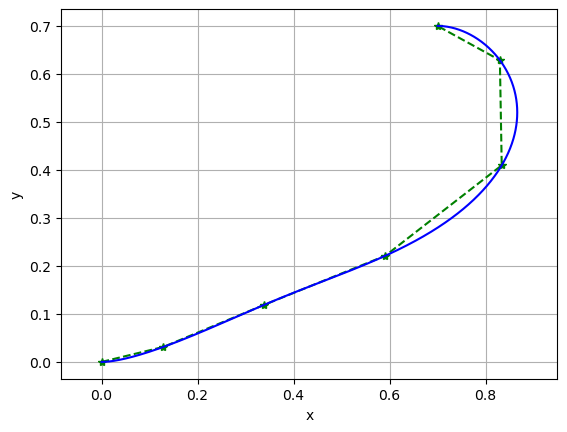

In [22]:
plt.plot(x,y,'*g--')
plt.plot(colloc_to_eval@x,
         colloc_to_eval@y,'b-')
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

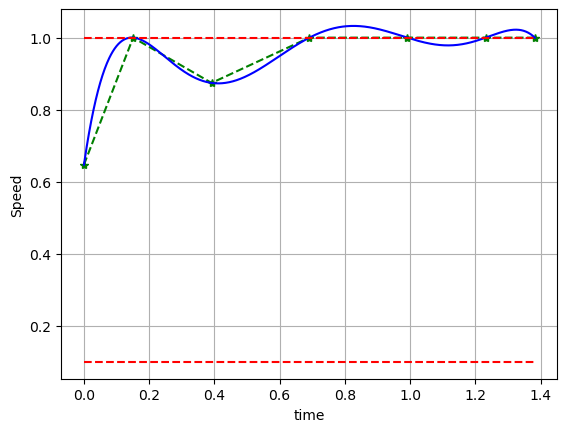

In [23]:
plt.plot(T*colloc_dist, v, '*g--')
plt.plot(T*eval_dist, colloc_to_eval@v, 'b-')
plt.plot([0,T], [vmax,vmax],'r--')
plt.plot([0,T], [vmin,vmin],'r--')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('Speed')
plt.show()

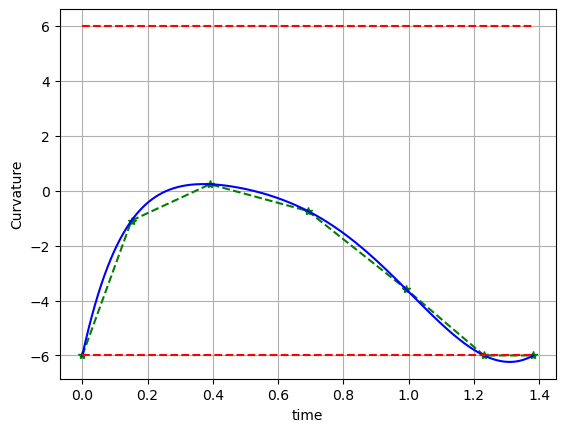

In [24]:
plt.plot(T*colloc_dist,k,'*g--')
plt.plot(T*eval_dist, colloc_to_eval@k, 'b-')
plt.plot([0,T], [kmax,kmax],'r--')
plt.plot([0,T], [-kmax,-kmax],'r--')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('Curvature')
plt.show()

### Verification via simulation

The polynomials shown interpolate the dynamics of the system, but they may not capture it accurately, for example if the order of the polynomials used is too low to represent the dynamics, or the placement of the interpolation points 'misses' areas of fast change. To verify that the solution found by collocation is reasonable, we can simulate the dynamics with the derived control values and compare the two.

<i>Try re-running the notebook with different values of 'num_colloc' to see the effect of the interpolation/collocation grid density on the dynamical accuracy of the solution.</i>

In [25]:
# This code simulates the vehicle dynamics using as input the control interpolating polynomials computed
# by the trajectory optimisation.

# =====

# Obtaining control values: calculate interpolating polynomials for velocity and steering functions
# Invert the Vandermonde matrix
vand_inv = np.linalg.inv(vand)
# Calculate interpolation coefficients for v and k
a_v = vand_inv@v
a_k = vand_inv@k

# Computing v at time t using interpolating polynomial
def calc_v(t):
    # Scale t into [0, 1] range
    tau = t / T
    # Take dot product of interpolation coefficients with interpolation basis functions evaluated at time tau
    # (1, tau, tau^2, tau^3, ...) to reconstruct the value of v at time tau.
    return np.dot(a_v, np.array([tau**i for i in range(num_colloc)]))

# Computing k at time t using interpolating polynomial
def calc_k(t):
    # Scale t into [0, 1] range
    tau = t / T
    # Take dot product of interpolation coefficients with interpolation basis functions evaluated at time tau
    # (1, tau, tau^2, tau^3, ...) to reconstruct the value of k at time tau.
    return np.dot(a_k, np.array([tau**i for i in range(num_colloc)]))

# =====

def dynamics(t, s):  # s: states
    x, y, h = s
    dx = calc_v(t)*np.sin(h)
    dy = calc_v(t)*np.cos(h)
    dh = calc_v(t)*calc_k(t)
    return dx, dy, dh

# Integrate dynamics
init_state = [x[0], y[0], h[0]]
sim = solve_ivp(dynamics, (0, T), init_state, max_step=1e-3)

x_sim, y_sim, h_sim = sim.y

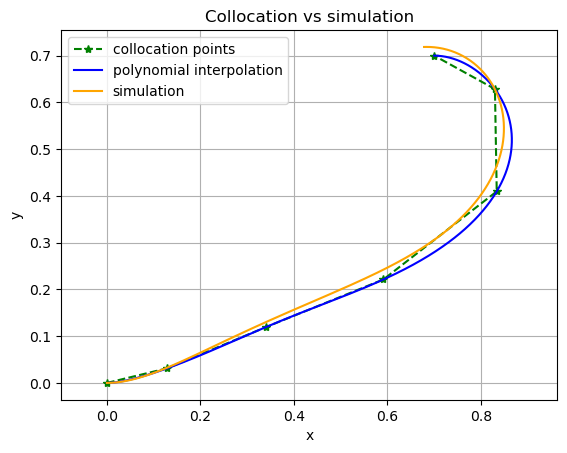

In [26]:
plt.plot(x,y,'*g--',label='collocation points')
plt.plot(colloc_to_eval@x,
         colloc_to_eval@y,'b-',label='polynomial interpolation')
plt.plot(x_sim,y_sim,'-',c='orange',label='simulation')
plt.axis('equal')
plt.grid('on')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title("Collocation vs simulation")
plt.show()

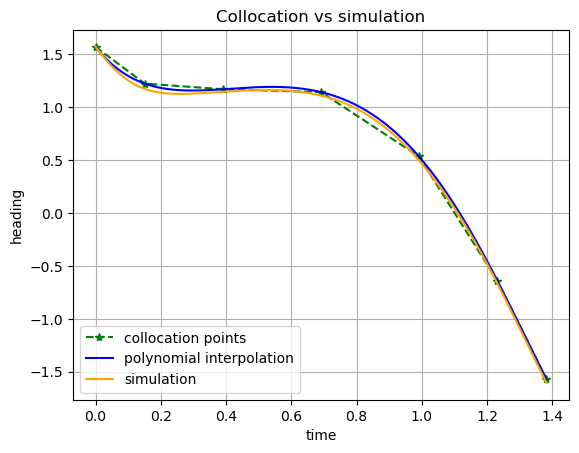

In [27]:
plt.plot(T*colloc_dist, h, '*g--',label='collocation points')
plt.plot(T*eval_dist, colloc_to_eval@h, 'b-',label='polynomial interpolation')
plt.plot(sim.t,h_sim,'-',c='orange',label='simulation')
plt.grid('on')
plt.xlabel('time')
plt.ylabel('heading')
plt.legend()
plt.title("Collocation vs simulation")
plt.show()

---

## Extra: interpolating polynomials

It can be interesting to look at the calculated interpolating polynomials. The set of interpolating polynomials used in this example $\{1, \tau, \tau^2, \dots\}$ doesn't produce anything unexpected, although it's interesting to note the large variation in the coefficients. Other interpolation systems such as the Lagrange interpolating polynomials can also be used, and yield more interesting results.

a_v: [   0.64738961    8.59117151  -71.87650754  249.95045166 -413.64028052
  325.30343047  -97.97565519]


Text(0.5, 0.98, 'Interpolating polynomials for v')

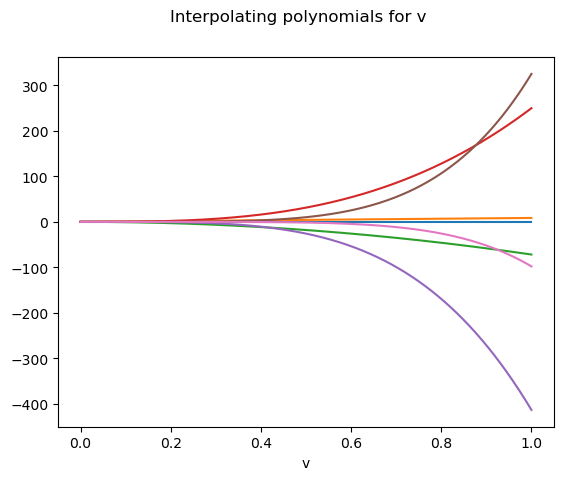

In [28]:
print(f"a_v: {a_v}")

fig, ax = plt.subplots()
tau = np.linspace(0, 1, 1000)
[ax.plot(tau, a_v[i]*(tau**i)) for i in range(num_colloc)]
ax.set_xlabel(r'$\tau$')
ax.set_xlabel('v')
fig.suptitle("Interpolating polynomials for v")

a_k: [   -6.            74.96229734  -357.56333555   883.32596151
 -1203.09043389   802.29714039  -199.93162981]


Text(0.5, 0.98, 'Interpolating polynomials for k')

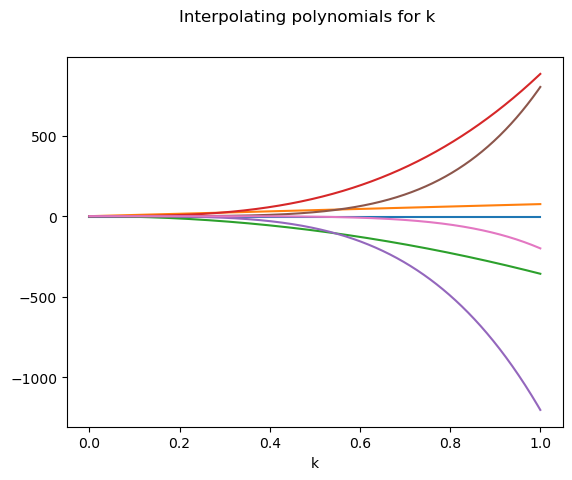

In [29]:
print(f"a_k: {a_k}")

fig, ax = plt.subplots()
tau = np.linspace(0, 1, 1000)
[ax.plot(tau, a_k[i]*(tau**i)) for i in range(num_colloc)]
ax.set_xlabel(r'$\tau$')
ax.set_xlabel('k')
fig.suptitle("Interpolating polynomials for k")